# <center> <b> One Class Image Classification </b></center> <br>

### **Work Flow:**  <br>
1. Importing packages and reading the dataset
2. ResNet50 : To featurize the image's
3. PCA : To get the most important features
4. Model Training
5. Predicting output of test data
6. Evaluating the model

## <center> <b> Models </b></center> <br>

### <center> <b> SVM + ResNET50 для извлечения признаков </b></center> <br>

#### importing

In [2]:
#Importing packages
# from google.colab import drive
import os
from tqdm import tqdm
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score , recall_score , f1_score

# import Augmentor
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

#### data processing

In [27]:
info_train = []

for root, __, files in os.walk(r"C:\My_projects\nuke\Spectrograms\nuke"):
    for f in files:
        if f.endswith(".jpg") or f.endswith(".png"):
            info_train.append(root + "/" + f)
for root, __, files in os.walk(r"C:\My_projects\nuke\Spectrograms\concatenate"):
    for f in files:
        if f.endswith(".jpg") or f.endswith(".png"):
            info_train.append(root + "/" + f)

In [6]:
print("Количество в обучающей выборке: " ,len(info_train))

Количество в обучающей выборке:  1601


In [23]:
info_test = []

for root, __, files in os.walk(r"C:\My_projects\nuke\Spectrograms\samples"):
    for f in files:
        if f.endswith(".jpg") or f.endswith(".PNG") or f.endswith(".png"):
            info_test.append(root + "/" + f)

# for root, __, files in os.walk(r"C:\My_projects\nuke\Spectrograms\other"):
#     for f in files:
#         if f.endswith(".jpg") or f.endswith(".PNG") or f.endswith(".png"):
#             info_test.append(root + "/" + f)

In [33]:
print("Количество в валидационной выборке : " ,len(info_test))

Количество в валидационной выборке :  10


#### ResNet50 : Для извлечения признаков из спектрограм

In [28]:
image_size = 224

train_img_paths = info_train
test_img_paths = info_test

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return(output)

#conversion of image to vector
X_train = read_and_prep_images(train_img_paths)
X_test = read_and_prep_images(test_img_paths)

In [29]:

resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights="imagenet", include_top=False, pooling='avg')  # Since top layer is the fc layer used for predictions

X_train = resnet_model.predict(X_train)
X_test = resnet_model.predict(X_test)

In [30]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

#### PCA : Для получения самых важных признаков

In [31]:
pca = PCA(n_components=0.95, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Explained variance percentage = 0.95


In [32]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

X_train_df.to_csv("final_features.csv" , index = False)
X_test_df.to_csv("final_features_test.csv" , index = False)

#### Model

In [3]:

train = pd.read_csv("final_features.csv")
test = pd.read_csv("final_features_test.csv")

In [4]:

train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,526,527,528,529,530,531,532,533,534,535
0,-0.83308,-1.203579,-0.172545,-0.505063,0.040423,-0.091269,1.054871,-0.068386,-1.157002,-1.161042,...,0.744576,1.508360,1.575709,0.063586,0.232411,0.720605,-1.016911,-0.428548,-2.289404,-1.68327
1,0.62513,-0.087482,-0.233197,0.967994,1.195991,-1.526914,0.514906,1.251963,0.477916,0.098974,...,2.560883,-1.112391,0.660202,-1.832862,-2.225050,-1.656799,0.066516,1.461908,1.396194,-0.45748


In [5]:

test.head(2)

,0,1,2,3,4,5,6,7,8,9,...,526,527,528,529,530,531,532,533,534,535
0,1.364567,0.300285,1.208550,-0.231785,0.050097,-0.090669,-0.443085,-1.111170,0.297109,-0.149488,...,0.066524,0.88706,0.871715,1.321460,1.101021,-0.519142,1.599030,-0.816902,-0.501587,0.713757
1,0.488841,0.097328,1.520236,0.158919,0.649007,-1.194553,0.317998,-0.105641,0.174672,0.979614,...,0.069221,0.39326,-0.131131,-0.899057,2.190158,-1.105991,1.328735,-0.395520,-0.576664,1.636731


In [6]:
oc_svm_clf = svm.OneClassSVM(kernel = "sigmoid" , nu=0.8)
oc_svm_clf.fit(train)

OneClassSVM(kernel='sigmoid', nu=0.8)

In [7]:
import pickle
filename = 'svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(oc_svm_clf, file)

In [8]:
oc_svm_preds = oc_svm_clf.predict(test)

In [9]:
oc_svm_preds

array([ 1,  1, -1,  1,  1,  1,  1,  1, -1, -1], dtype=int64)

In [10]:
labels = ["Выстрелы" if i == 1 else "Не Выстрелы" for i in oc_svm_preds]

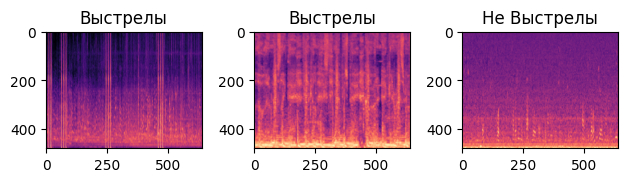

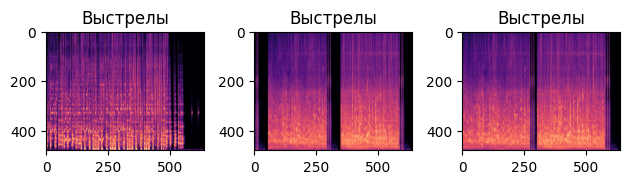

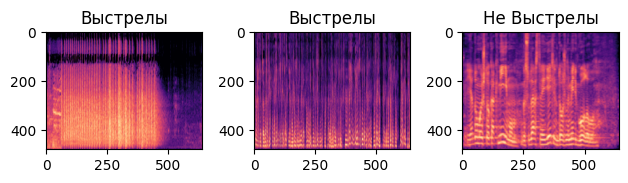

In [11]:
#displaying the test images with the predicted label

#counter to display 3 images per row
c = 1
correct_labels = [1, -1, -1, -1, 1, 1, 1, -1, 1, 1]
correct_labels = ["Выстрелы" if i == 1 else "Не Выстрелы" for i in correct_labels]
for root, __, files in os.walk(r"C:\My_projects\nuke\Spectrograms\samples"):
    for f in files[:9]:
        if f.endswith(".jpg") or f.endswith(".PNG") or f.endswith(".png"):
            plt.subplot(3,3,c)
            img  = mpimg.imread(root + "/" + f)
            plt.title(str(labels[c-1]), )
            plt.imshow(img)
            if (c%3==0):
                plt.tight_layout()
                plt.show()
            c = c+1

#### Evaluating the model

In [49]:
train_model = Counter(oc_svm_clf.predict(train).tolist())
test_model =  Counter(oc_svm_clf.predict(test).tolist())

In [50]:
#getting the predicted value
y_train = np.ones(len(info_train))
y_train_pred = oc_svm_clf.predict(train)

y_test = np.array([1, -1, -1, -1, 1, 1, 1, -1, 1, 1])
y_test_pred = oc_svm_preds

In [52]:
#model performance

print("Train Precisison score : " , precision_score(y_train , y_train_pred))
print("Test Precisison score : " , precision_score(y_test , y_test_pred))

print("\n\nTrain Recall score : " , recall_score(y_train , y_train_pred))
print("Test Recall score : " , recall_score(y_test , y_test_pred))

print("\n\nTrain F1 score : " , f1_score(y_train , y_train_pred))
print("Test F1 score : " , f1_score(y_test , y_test_pred))

Train Precisison score :  1.0
Test Precisison score :  0.5714285714285714


Train Recall score :  0.21111805121798877
Test Recall score :  0.6666666666666666


Train F1 score :  0.3486333161423414
Test F1 score :  0.6153846153846154


### <center> <b> Autoencoder </b></center> <br>

#### process data

In [12]:
import numpy as np
import librosa.display
import os
import matplotlib.pyplot as plt

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_mp3(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.mp3', '.png'))
        print(input_file, output_file)
        create_spectrogram(input_file, output_file)

In [13]:
# import keras.utils as image
from keras.preprocessing import image

def load_images_from_path(path, label, method='direct'):
    images = []
    labels = []
    if method == 'direct':
        for file in os.listdir(path):
            # if file.startswith('converted_'):
            images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
            labels.append((label))
    else:
        images.append(image.img_to_array(image.load_img(f'{path}.png' , target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 20, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

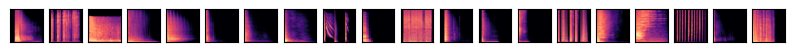

In [14]:
images, labels = load_images_from_path('Spectrograms/nuke', 0)
show_images(images)
    
x += images
y += labels

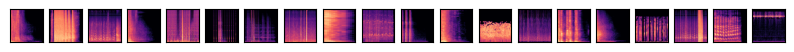

In [15]:
images, labels = load_images_from_path('Spectrograms/concatenate', 0)
show_images(images)
    
x += images
y += labels

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

#### model

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2DTranspose, Input
from keras import Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError
clear_session()

input_img = Input(shape=(224, 224, 3))
x = (Conv2D(32, (3, 3), activation='relu', padding='same'))(input_img)
x = (BatchNormalization())(x)
x = (MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = (Dropout(0.25))(x)
x = (Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))(x)
x = (BatchNormalization()) (x)
x = (MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = (Dropout(0.25))(x)
x = (Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))(x)
x = (BatchNormalization()) (x)
x = (MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = (Dropout(0.25))(x)
x = (Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))(x)
encoded = (BatchNormalization())(x)

# x = (Conv2DTranspose(256, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))(encoded)
# x = (Dropout(0.25))(x)

x = (BatchNormalization())(encoded)
x = (Conv2DTranspose(128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))(x)
x = (Dropout(0.25))(x)

x = (BatchNormalization()) (x)
x = (Conv2DTranspose(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))(x)
x = (Dropout(0.25))(x)

x = (BatchNormalization())(x)
x = (Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'))(x)

decoded = (Conv2DTranspose(3, (3, 3), activation='relu', padding='same'))(x)



autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanSquaredError(), MeanAbsolutePercentageError()])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496 

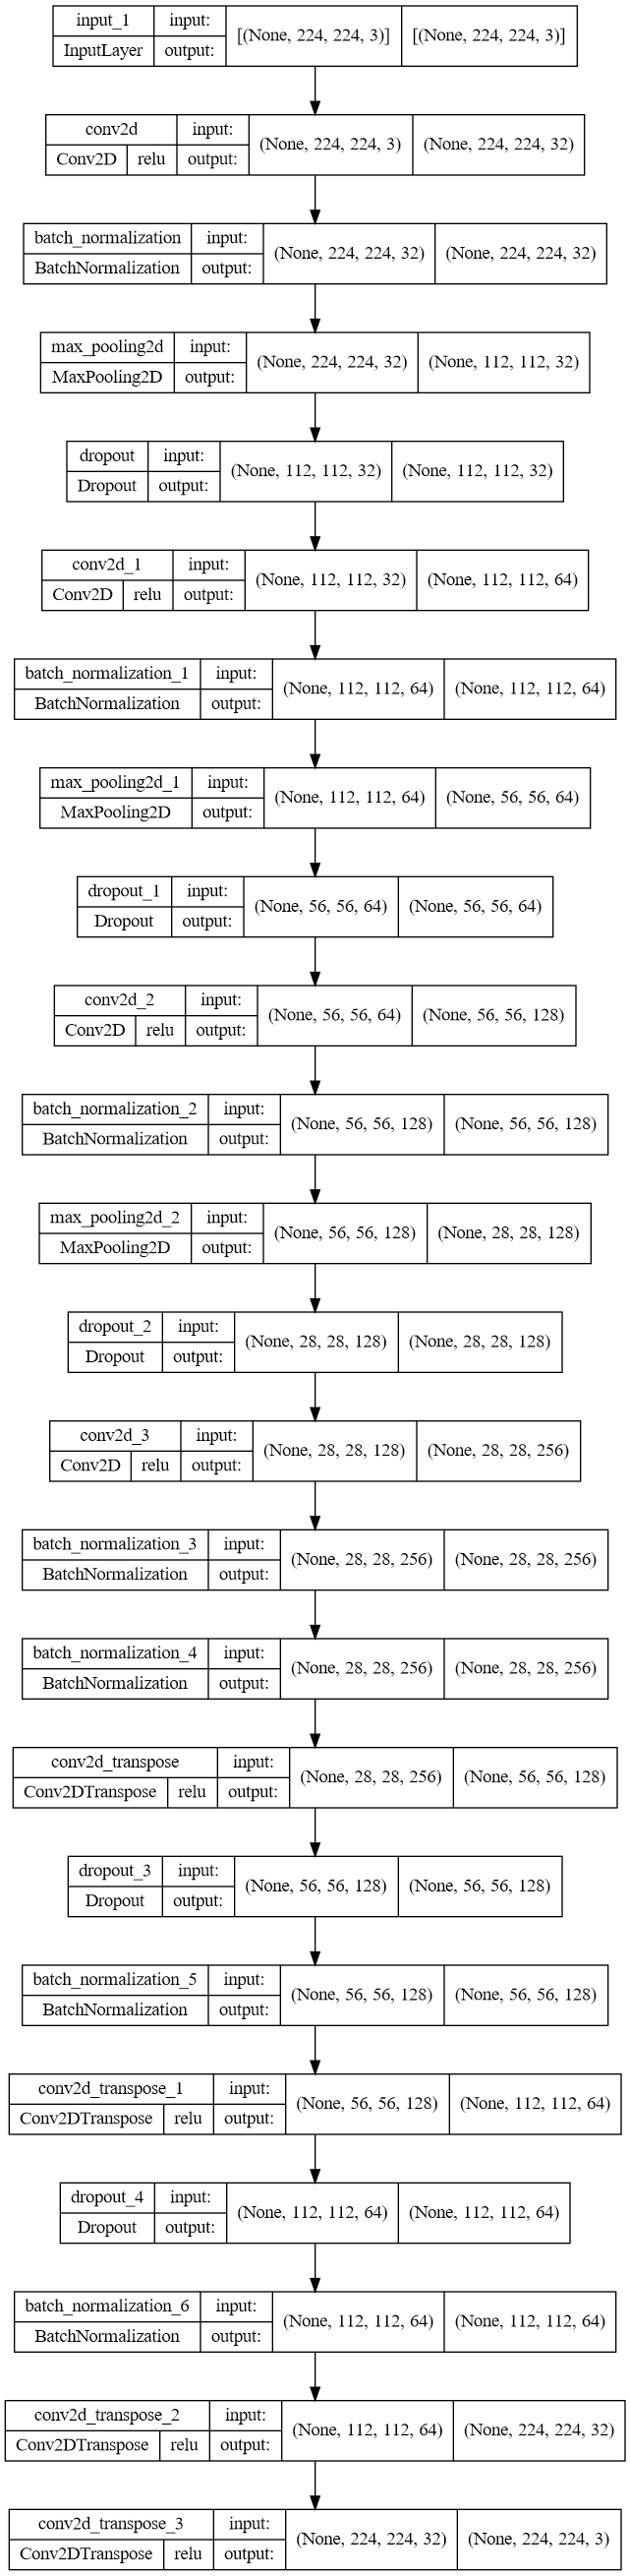

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, r'C:\My_projects\nuke\metrics\architecture\Autoencoder.png', show_shapes=True, show_layer_activations = True)

In [19]:
hist = autoencoder.fit(x_train_norm, x_train_norm, validation_data=(x_test_norm, x_test_norm), epochs=20, batch_size=32)

Epoch 1/20
43/43 [==============================] - 18s 235ms/step - loss: 0.0446 - root_mean_squared_error: 0.2111 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0446 - mean_absolute_percentage_error: 2637897.0000 - val_loss: 0.0593 - val_root_mean_squared_error: 0.2436 - val_mean_absolute_error: 0.1965 - val_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 24406516.0000
Epoch 2/20
43/43 [==============================] - 8s 174ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - mean_absolute_error: 0.0742 - mean_squared_error: 0.0137 - mean_absolute_percentage_error: 1653409.8750 - val_loss: 0.0489 - val_root_mean_squared_error: 0.2212 - val_mean_absolute_error: 0.1779 - val_mean_squared_error: 0.0489 - val_mean_absolute_percentage_error: 24572934.0000
Epoch 3/20
43/43 [==============================] - 8s 175ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - mean_absolute_error: 0.0648 - mean_squared_error: 0.0107 - mean_absolute_percentage_erro

In [20]:
autoencoder.save(r'C:\My_projects\nuke\models\autoencoder')

INFO:tensorflow:Assets written to: C:\My_projects\nuke\models\autoencoder\assets


#### test

In [21]:
reconstruction_errors = np.mean(np.square(x_train_norm - autoencoder.predict(x_train_norm)), axis=1)
threshold = np.percentile(reconstruction_errors, 95)

In [22]:
threshold

0.017881708685308674

In [175]:
images, labels = load_images_from_path('Spectrograms/samples/Chiikawa Usagi', 2, 'l')
# show_images(images)
    
x = images
y_real = labels
images, labels = load_images_from_path('Spectrograms/samples/IMG_9658', 0, 'l')
x += images
y_real += labels

In [156]:
predictions = autoencoder.predict(np.array(x) / 255)
test_errors = np.mean(np.square(np.array(x) / 255 - predictions), axis=1)
anomalies = test_errors > threshold

In [174]:
np.count_nonzero(anomalies[1]) > 0.15 * anomalies[0].size

False

In [179]:
class_labels = ['Выстрелы', 'Фейерверки', 'Другие']
for k in range(len(y_real)):
    print("Выстрелы:", np.count_nonzero(anomalies[k]) > 0.15 * anomalies[0].size, 'реальное:', class_labels[y_real[k]])
    # for i, label in enumerate(class_labels):
        # print(f'{label}: {y[k][i]}')

Выстрелы: True реальное: Другие
Выстрелы: False реальное: Выстрелы


#### visualize

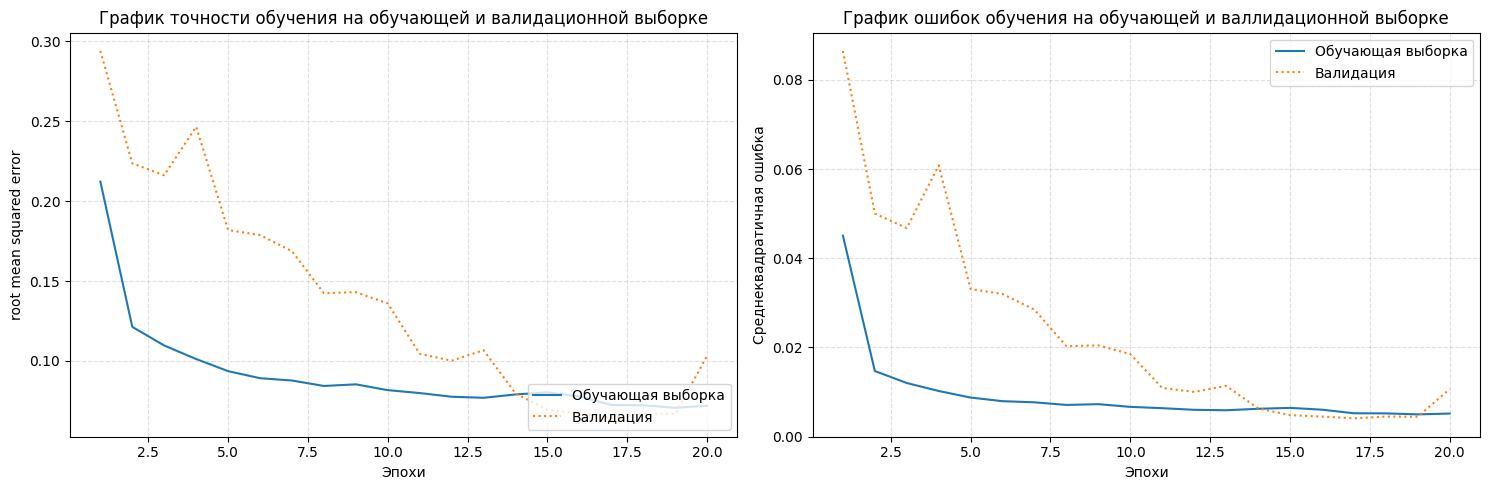

In [26]:
root_mean_squared_error = hist.history['root_mean_squared_error']
mean_squared_error = hist.history['mean_squared_error']

val_root_mean_squared_error = hist.history['val_root_mean_squared_error']
val_mean_squared_error = hist.history['val_mean_squared_error']

epochs = list(range(1, len(root_mean_squared_error) + 1))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, root_mean_squared_error, '-', label='Обучающая выборка')
plt.plot(epochs, val_root_mean_squared_error, ':', label='Валидация')
plt.title('График точности обучения на обучающей и валидационной выборке')
plt.xlabel('Эпохи')
plt.ylabel('root mean squared error')
plt.legend(loc='lower right')
plt.grid(True, color='gray', alpha = 0.25, linestyle='--')
plt.tight_layout()

# plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_squared_error, '-', label='Обучающая выборка')
plt.plot(epochs, val_mean_squared_error, ':', label='Валидация')
plt.title('График ошибок обучения на обучающей и валлидационной выборке')
plt.xlabel('Эпохи')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend(loc='upper right')
plt.grid(True, color='gray', alpha = 0.25, linestyle='--')
plt.tight_layout()
plt.savefig(r'C:\My_projects\nuke\metrics\matplot\One_Class_Autoencoder_metrics_root_mean_squared_error_and_mean_squared_error.png')
plt.show()

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py

root_mean_squared_error = hist.history['root_mean_squared_error']
mean_squared_error = hist.history['mean_squared_error']

val_root_mean_squared_error = hist.history['val_root_mean_squared_error']
val_mean_squared_error = hist.history['val_mean_squared_error']

epochs = list(range(1, len(root_mean_squared_error) + 1))

fig = make_subplots(rows=1, cols=2, subplot_titles=("<b>root_mean_squared_error</b>", "<b>Mean squared error</b>",), horizontal_spacing=0.05)

# root_mean_squared_error
fig.add_trace(go.Scatter(x=list(epochs), y=root_mean_squared_error, legendgroup='<b>Training</b>', name='<b>Training</b>',
                            line=dict(shape='spline', smoothing=0.8, color='#636efb'), mode='markers+lines', marker=dict(color='#636efb')), row=1, col=1)
fig.add_trace(go.Scatter(x=list(epochs), y=val_root_mean_squared_error, legendgroup='<b>Validation</b>', name='<b>Validation</b>',
                            line=dict(shape='spline', smoothing=0.8, dash='dot', color='red'), mode='markers+lines', marker=dict(color='red')), row=1, col=1)

# mean_squared_error
fig.add_trace(go.Scatter(x=list(epochs), y=mean_squared_error, legendgroup='<b>Training</b>', name='<b>Training</b>', showlegend=False,
                            line=dict(shape='spline', smoothing=0.8, color='#636efb'), mode='markers+lines', marker=dict(color='#636efb')), row=1, col=2)
fig.add_trace(go.Scatter(x=list(epochs), y=val_mean_squared_error, legendgroup='<b>Validation</b>', name='<b>Validation</b>', showlegend=False,
                            line=dict(shape='spline', smoothing=0.8, dash='dot', color='red'), mode='markers+lines', marker=dict(color='red')), row=1, col=2)


fig.update_traces(hovertemplate='Epoch: %{x}<br>Value: %{y}')

fig.update_yaxes(title_text="<b>Показатели</b>")
fig.update_xaxes(title_text="<b>Эпохи</b>")
fig.update_layout(legend=dict(font=dict(size=14), bgcolor='lightgray'))


fig.update_layout(
    height=550, 
    width=2000, 
    title_text="<b>Метрики обучения</b>",
    legend=dict(
        font=dict(size=14),
        bgcolor='rgba(240, 240, 240, 0.5)',
        bordercolor='rgba(200, 200, 200, 1)',
        borderwidth=1,
    ),
    plot_bgcolor='rgba(210, 210, 210, 0.5)',
    
    # paper_bgcolor='rgba(250, 250, 250, 1)'
)
fig.update_xaxes(range=[0.5, max(epochs)+0.3])
py.plot(fig, filename=r'C:\My_projects\nuke\metrics\plotly\One_Class_Autoencoder_metrics_root_mean_squared_error_and_mean_squared_error.html')
fig.write_image(r"C:\My_projects\nuke\metrics\plotly\One_Class_Autoencoder_metrics_root_mean_squared_error_and_mean_squared_error.svg")
fig.show()

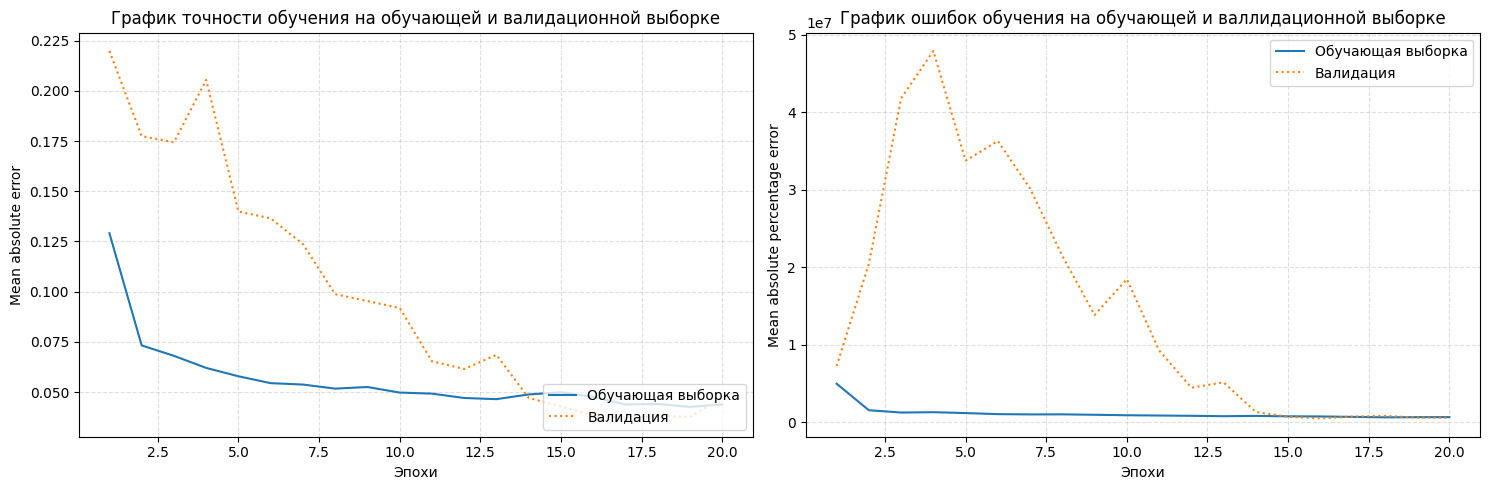

In [28]:
mean_absolute_error = hist.history['mean_absolute_error']
mean_absolute_percentage_error = hist.history['mean_absolute_percentage_error']

val_mean_absolute_error = hist.history['val_mean_absolute_error']
val_mean_absolute_percentage_error = hist.history['val_mean_absolute_percentage_error']

epochs = list(range(1, len(mean_absolute_error) + 1))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_absolute_error, '-', label='Обучающая выборка')
plt.plot(epochs, val_mean_absolute_error, ':', label='Валидация')
plt.title('График точности обучения на обучающей и валидационной выборке')
plt.xlabel('Эпохи')
plt.ylabel('Mean absolute error')
plt.legend(loc='lower right')
plt.grid(True, color='gray', alpha = 0.25, linestyle='--')
plt.tight_layout()

# plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_absolute_percentage_error, '-', label='Обучающая выборка')
plt.plot(epochs, val_mean_absolute_percentage_error, ':', label='Валидация')
plt.title('График ошибок обучения на обучающей и валлидационной выборке')
plt.xlabel('Эпохи')
plt.ylabel('Mean absolute percentage error')
plt.legend(loc='upper right')
plt.grid(True, color='gray', alpha = 0.25, linestyle='--')
plt.tight_layout()
plt.savefig(r'C:\My_projects\nuke\metrics\matplot\One_Class_Autoencoder_metrics_mean_absolute_error_and_mean_absolute_percentage_error.png')
plt.show()

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py

mean_absolute_error = hist.history['mean_absolute_error']
mean_absolute_percentage_error = hist.history['mean_absolute_percentage_error']

val_mean_absolute_error = hist.history['val_mean_absolute_error']
val_mean_absolute_percentage_error = hist.history['val_mean_absolute_percentage_error']

epochs = list(range(1, len(mean_absolute_error) + 1))

fig = make_subplots(rows=1, cols=2, subplot_titles=("<b>Mean absolute error</b>", "<b>Mean absolute percentage error</b>",), horizontal_spacing=0.05)

# mean_absolute_error
fig.add_trace(go.Scatter(x=list(epochs), y=mean_absolute_error, legendgroup='<b>Training</b>', name='<b>Training</b>',
                            line=dict(shape='spline', smoothing=0.8, color='#636efb'), mode='markers+lines', marker=dict(color='#636efb')), row=1, col=1)
fig.add_trace(go.Scatter(x=list(epochs), y=val_mean_absolute_error, legendgroup='<b>Validation</b>', name='<b>Validation</b>',
                            line=dict(shape='spline', smoothing=0.8, dash='dot', color='red'), mode='markers+lines', marker=dict(color='red')), row=1, col=1)

# mean_absolute_percentage_error
fig.add_trace(go.Scatter(x=list(epochs), y=mean_absolute_percentage_error, legendgroup='<b>Training</b>', name='<b>Training</b>', showlegend=False,
                            line=dict(shape='spline', smoothing=0.8, color='#636efb'), mode='markers+lines', marker=dict(color='#636efb')), row=1, col=2)
fig.add_trace(go.Scatter(x=list(epochs), y=val_mean_absolute_percentage_error, legendgroup='<b>Validation</b>', name='<b>Validation</b>', showlegend=False,
                            line=dict(shape='spline', smoothing=0.8, dash='dot', color='red'), mode='markers+lines', marker=dict(color='red')), row=1, col=2)


fig.update_traces(hovertemplate='Epoch: %{x}<br>Value: %{y}')

fig.update_yaxes(title_text="<b>Показатели</b>")
fig.update_xaxes(title_text="<b>Эпохи</b>")
fig.update_layout(legend=dict(font=dict(size=14), bgcolor='lightgray'))


fig.update_layout(
    height=550, 
    width=2000, 
    title_text="<b>Метрики обучения</b>",
    legend=dict(
        font=dict(size=14),
        bgcolor='rgba(240, 240, 240, 0.5)',
        bordercolor='rgba(200, 200, 200, 1)',
        borderwidth=1,
    ),
    plot_bgcolor='rgba(210, 210, 210, 0.5)',
    
    # paper_bgcolor='rgba(250, 250, 250, 1)'
)
fig.update_xaxes(range=[0.5, max(epochs)+0.3])
py.plot(fig, filename=r'C:\My_projects\nuke\metrics\plotly\One_Class_Autoencoder_metrics_mean_absolute_error_and_mean_absolute_percentage_error.html')
fig.write_image(r"C:\My_projects\nuke\metrics\plotly\One_Class_Autoencoder_metrics_mean_absolute_error_and_mean_absolute_percentage_error.svg")
fig.show()